In [46]:
# Import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/subin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/subin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/subin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# Load the datasets
train_df = pd.read_csv('../datasets/twitter_dataset/twitter_training.csv', header=None)
test_df = pd.read_csv('../datasets/twitter_dataset/twitter_validation.csv', header=None)

# Set column names
train_df.columns = ['id', 'topic', 'sentiment', 'text']
test_df.columns = ['id', 'topic', 'sentiment', 'text']

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print(train_df.head())

Training data shape: (74682, 4)
Test data shape: (1000, 4)
     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [48]:
# Check sentiment distribution
print("Sentiment values in training data:")
print(train_df['sentiment'].value_counts())

print("\nSentiment values in test data:")
print(test_df['sentiment'].value_counts())

Sentiment values in training data:
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Sentiment values in test data:
sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


In [49]:
# Keep only positive and negative sentiments for binary classification
train_df = train_df[train_df['sentiment'].isin(['Positive', 'Negative'])]
test_df = test_df[test_df['sentiment'].isin(['Positive', 'Negative'])]

print("After filtering:")
print("Training data:", len(train_df))
print("Test data:", len(test_df))

After filtering:
Training data: 43374
Test data: 543


In [50]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove links and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            cleaned_tokens.append(lemmatizer.lemmatize(token))
    
    return ' '.join(cleaned_tokens)

# Test the function
print("Example:")
sample = "I love my life! @user https://subin.com"
print("Original:", sample)
print("Cleaned:", clean_text(sample))

Example:
Original: I love my life! @user https://subin.com
Cleaned: love life


In [51]:
# Clean the text data
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Remove empty texts
train_df = train_df[train_df['clean_text'].str.len() > 0]
test_df = test_df[test_df['clean_text'].str.len() > 0]

print("Data after cleaning:")
print("Training:", len(train_df))
print("Test:", len(test_df))

# Show examples -> first 3 samples
print("\nExamples of cleaned text:")
for i in range(3):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned: {train_df['clean_text'].iloc[i]}")
    print()

Data after cleaning:
Training: 42346
Test: 542

Examples of cleaned text:
Original: im getting on borderlands and i will murder you all ,
Cleaned: getting borderland murder

Original: I am coming to the borders and I will kill you all,
Cleaned: coming border kill

Original: im getting on borderlands and i will kill you all,
Cleaned: getting borderland kill



In [52]:
# Convert sentiments to numbers
train_df['label'] = train_df['sentiment'].map({'Positive': 1, 'Negative': 0})
test_df['label'] = test_df['sentiment'].map({'Positive': 1, 'Negative': 0})

# Prepare X and y
X_train = train_df['clean_text']
y_train = train_df['label']
X_test = test_df['clean_text']
y_test = test_df['label']

print("Final data:")
print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")
print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

print("\nLabel distribution:")
print("Training:", y_train.value_counts().to_dict())
print("Test:", y_test.value_counts().to_dict())

Final data:
X_train: 42346
y_train: 42346
X_test: 542
y_test: 542

Label distribution:
Training: {0: 22043, 1: 20303}
Test: {1: 277, 0: 265}


In [53]:
# Create TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF vectors created")
print("Training shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

TF-IDF vectors created
Training shape: (42346, 5000)
Test shape: (542, 5000)


In [54]:
# Train the MultinomialNB Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

print("Model trained successfully!")

Model trained successfully!


In [55]:
# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.889


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89       265
    Positive       0.90      0.88      0.89       277

    accuracy                           0.89       542
   macro avg       0.89      0.89      0.89       542
weighted avg       0.89      0.89      0.89       542



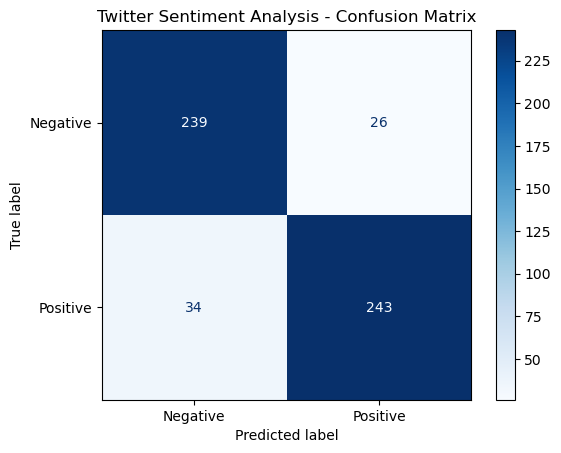

In [59]:
# Show results
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Twitter Sentiment Analysis - Confusion Matrix')
plt.show()


In [57]:
# Function to predict sentiment of new text
def predict_sentiment(text):
    cleaned = clean_text(text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# Test with sample tweets
test_tweets = [
    "I love this movie!",
    "This is terrible",
    "Best day ever!",
    "I hate waiting in traffic"
]

print("Testing new tweets:")
for tweet in test_tweets:
    result = predict_sentiment(tweet)
    print(f"'{tweet}' -> {result}")

Testing new tweets:
'I love this movie!' -> Positive
'This is terrible' -> Negative
'Best day ever!' -> Positive
'I hate waiting in traffic' -> Negative


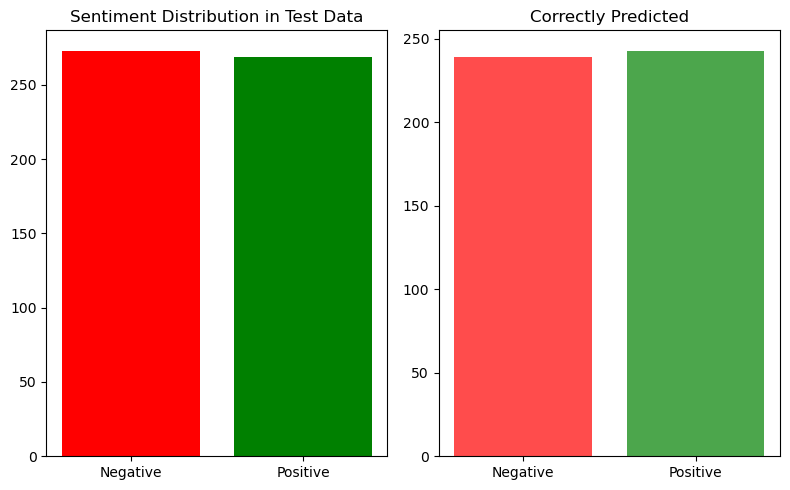

Final Accuracy: 88.9%


In [58]:
# Plot accuracy
import matplotlib.pyplot as plt

labels = ['Negative', 'Positive']
values = [cm[0,0]+cm[1,0], cm[0,1]+cm[1,1]]

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, values, color=['red', 'green'])
plt.title('Sentiment Distribution in Test Data')

plt.subplot(1, 2, 2)
correct = [cm[0,0], cm[1,1]]
plt.bar(labels, correct, color=['red', 'green'], alpha=0.7)
plt.title('Correctly Predicted')
plt.tight_layout()
plt.show()

print(f"Final Accuracy: {accuracy:.1%}")